In [5]:
import os
import random
import numpy as np
import pandas as pd
import networkx as nx
from datetime import date
import matplotlib.pyplot as plt

In [6]:
populationSize = 4  # Bosse et al. (2015) used 10 agents, so we use 11 to pick out a leader and have 10 agents interacting with each other
style = "High"  # designate "High" or "Low" to indicate the leader's emotion management ability

todaysDate = date.today().strftime("%m_%d_%Y")  # get today's date in the format MM_DD_YYYY
basefolder = rf"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\{todaysDate}"  # in the quotations, put the name of the main folder in which you want the results to be saved to  
folderpath = os.path.join(basefolder, f"Leader_{style}")  # create a folder for the leader's emotion management ability


def save_results(avg_emotion_runs, folderpath, images=None):
    '''
    Save simulation results and any associated plots (save each scenario).

    Parameters:
    - avg_emotion_runs: list of lists of average emotion history (one list per run)
    - folderpath: path to the parent save directory
    - images: optional list of (matplotlib.figure.Figure, filename) tuples
    '''
    fullpath = os.path.join(folderpath, "Final Results")
    os.makedirs(fullpath, exist_ok=True)

    # Save as DataFrame with time steps as index, runs as columns
    df = pd.DataFrame(avg_emotion_runs).T
    df.columns = [f"Run_{i+1}" for i in range(len(avg_emotion_runs))]
    df.index.name = "Time"
    df.to_csv(os.path.join(fullpath, f"Avg_Emotion_Evolution_Over_30_Simulations_{style}.csv"))

    if images:
        for fig, filename in images:
            figpath = os.path.join(fullpath, filename)
            fig.savefig(figpath)
            fig.clf()

    print(f"Simulation results saved to {fullpath}")

In [7]:
def initialize(seed=None):
    '''
    Initialization function of simulation environment -- setup the variables.
    (D) = dynamic parameter (continuously updated) and (S) = static parameter (fixed)
    The intervals used have a uniform/gaussian distribution.
    Agent parameters:
        emotion (D): How an agent feels towards the change. Defined within the interval [-1, 1] following a beta distribution to skew towards the negative side.
                     The purpose behind the interval is because we want to see how a leader's emotional aperature dictates the evolution of the emotion contagion which gives more meaningful results when emotions initially tend more negative (encourages the random number picker towards negative).
        expressiveness (S): The degree to which an agent would display their emotion. [0,1]
        delta (S): Susceptibility to being influenced. This can also be thought of as how resistant an agent may be (stubborness, strong-headedness, etc.)
        amplification (D): How much an agent's emotion is amplified when interacting with another agent. This is a combination of other parameters
        bias (D): How much an agent's emotion is biased towards similar emotions. This is a combination of other parameters
    Leader parameters:
        emotion (S): Value = 1. We assume the leader is completely on board (feels fully positive) about the change.
        charisma (S): Leader's ability to influence the team. This is a value between 0 and 0.5, arbitrarily chosen by us
        emotionManagementAbility (S): Leader's ability to manage the sentiments amongst the team [H,L]. H = high ability, L = low ability
        interventionThreshold (S): what the average sentiment amongst the team needs to be in order for the leader to intervene 
    Other:
        intimacyMatrix (S): Represents agent-to-agent relationships (how close they are to each other) [0,1]. Explicitly indicates probability of an interaction between a pair of agents (one-way intitiation). 
                            Leader is currently excluded from the assigment of intimacy between it and it's team members.
                            Intimacies are asymmetrical amongst agent pairs (i.e. how close agentA feels to agentB and how close agentB feels to agentA need not be the same).
    '''
    global agents, leader, intimacyMatrix # create global variables so that they are readily accessible outside of this function (on the basis that this function is called before the variables within are needed to be used elsewhere)

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    agents = []  # initialize list of agents -- simple and dynamic data structure, e.g. lists can change in size (meaning agents added or removed during simulation -- though we are not doing this); order is preservered, thus ensuring agents are consistently/simply iterated over
    for _ in range(populationSize):  # for each agent in the population
        newAgent = {
            'emotion': -1 + 2 * np.random.beta(2, 5), 
            'delta': random.uniform(0, 1),
            'expressiveness': random.uniform(0,1),
            'amplification': random.uniform(0,1),
            'bias': random.uniform(0,1)
            }  # dictionary for parameter readability
        agents.append(newAgent)  # add agent to list
    

    leader = random.choice(agents)  # randomly select an agent from the list to designate as leader 
    agents.remove(leader)  # remove it from the agents list as they will behave differently and their parameters are going to be changed below
    

    ### Update leader parameters
    del leader['delta']  # remove this and below as they are not needed for the leader
    del leader['expressiveness']
    del leader['amplification']
    del leader['bias']

    leader['emotion'] = 1  # fix leader emotion
    
    
    # add parameters
    emotionManagementAbility = style
    if emotionManagementAbility == 'High':
        leader.update({'emotionManagementAbility': 'High'})
        leader.update({'interventionThreshold': 0.4})  # we're only playing around with this aspect of leader aperture, so we only vary this parameter
        leader.update({'charisma': 0.25})
    else:
        leader.update({'emotionManagementAbility': 'Low'})
        leader.update({'interventionThreshold': 0.2})
        leader.update({'charisma': 0.25})

    ### Leader-agent weights -- future consideration
    #leaderAgentWeights = np.random(random.uniform(0,1), (populationSize-1, 1))

    # assign an index to each agent for easy access later on -- this allows to have a one-to-one mapping between the agents list and intimacy matrix indices
    for idx, agent in enumerate(agents):
        agent['index'] = idx  

    ### Intimacy weights (agent-wise)
    intimacyMatrix = np.random.uniform(0,1, (populationSize-1, populationSize-1))
    np.fill_diagonal(intimacyMatrix, 0)  # along the diagonal are the self-to-self pairs (agentA, agentA), so we may assign a weight of 0
    intimacyMatrix = intimacyMatrix/intimacyMatrix.sum(axis=1, keepdims=True)  # normalise the matrix so we could treat these directly as probabilities (for what idk, but it is a thought)


    agents[0]['amplification'] = 0
    agents[1]['amplification'] = 0
    agents[2]['amplification'] = 0
    agents[0]['delta'] = 0
    #agents[1]['delta'] = 0
    #agents[2]['delta'] = 0.5     
    agents[0]['expressiveness'] = 0
    agents[0]['emotion'] = 0.3
    agents[1]['emotion'] = 0.1
    agents[2]['emotion'] = 1


In [8]:
def emotional_valence_update(agentA, agentB, agentA_index, agentB_index):  # are the matrix and dictionary indices aligning?
    '''
    For updating the emotional valence of each agent when they interact with the other agents.
    For contagionStrength, one may also think of it as influence strength
    '''
    # initialize the absolute difference dictionary if the pair is not already in there
    if (agentB_index, agentA_index) not in absoluteDiffEmoDict:  # if the pair has not been seen before, initialize it. It says the dictionary is undefined because it's not declared in this cell/code block, but it's okay since it's declared globally in the later on where the function is called
        absoluteDiffEmoDict[(agentB_index, agentA_index)] = 0
    if (agentA_index, agentB_index) not in absoluteDiffEmoDict:
        absoluteDiffEmoDict[(agentA_index, agentB_index)] = 0    
    
    # Lets set up the variables for the Bosse et al. (2015) model
    initial_qA = agentA['emotion']  # emotion before update
    initial_qB = agentB['emotion']

    # we gotta watch out for gamma since it's the contagion strength parameter. Higher the value = higher contagion and thus faster convergence
    gamma_A = sum(sender['expressiveness']*intimacyMatrix[sender['index'], agentA['index']]*agentA['delta'] for sender in agents if sender != agentA)
    gamma_B = sum(sender['expressiveness']*intimacyMatrix[sender['index'], agentB['index']]*agentB['delta'] for sender in agents if sender != agentB)

    eta_A = agentA['amplification']
    eta_B = agentB['amplification']

    beta_A = agentA['bias']
    beta_B = agentB['bias']

    groupEmos_A = sum(cat['expressiveness']*intimacyMatrix[cat['index'], agentA['index']] for cat in agents if cat != agentA)  # this is the denominator in w
    qstar_A = sum(
        ((sender['expressiveness']*intimacyMatrix[sender['index'], agentA['index']]) / groupEmos_A)*sender['emotion'] for sender in agents if sender != agentA
        )
    
    groupEmos_B = sum(cat['expressiveness']*intimacyMatrix[cat['index'], agentB['index']] for cat in agents if cat != agentB)
    qstar_B = sum(
        ((sender['expressiveness']*intimacyMatrix[sender['index'], agentB['index']]) / groupEmos_B)*sender['emotion'] for sender in agents if sender != agentB
        )

    PI_A = 1 - (1 - qstar_A)*(1 - initial_qA)
    NI_A = qstar_A*initial_qA

    PI_B = 1 - (1 - qstar_B)*(1 - initial_qB)
    NI_B = qstar_B*initial_qB

    
    agentA['emotion'] += gamma_A*(eta_A*(beta_A*PI_A + (1-beta_A)*NI_A) + (1 - eta_A)*qstar_A - initial_qA)
    agentA['emotion'] = np.clip(agentA['emotion'], -1, 1)  # clip the emotion to be within [-1, 1]      
    absoluteDiffEmoDict[(agentB_index, agentA_index)] += abs(initial_qA - agentA['emotion'])


    agentB['emotion'] += gamma_B*(eta_B*(beta_B*PI_B + (1-beta_B)*NI_B) + (1 - eta_B)*qstar_B - initial_qB)
    agentB['emotion'] = np.clip(agentB['emotion'], -1, 1)  # clip the emotion to be within [-1, 1]
    absoluteDiffEmoDict[(agentA_index, agentB_index)] += abs(initial_qB - agentB['emotion'])

In [9]:
def avgEmotion(agents):
    '''
    Calculate average emotion valence amongst the team.
    '''
    return (sum(agent['emotion'] for agent in agents))/len(agents)

In [10]:
def agent_interaction(): 
    '''
    Define inter-agent interactions. 
    Since their intimacy is defined using a probabilty, we say if that is a above a randomly generated number in [0,1], that is an interaction.
    '''
    global agents, emotionHistory, avgEmotionHistory

    buddies = []
    for i, agentA in enumerate(agents):  # for each index i and the agent, agentA, at that index in agents list (NOTE: using enumerate() allows us to easily get the indices in the agents list which we later use to access the agent objects)
        for j, agentB in enumerate(agents):  # same as above but we use a different letter to help differentiate from above because
            if (i != j):  # we of course do not want to select the same agent haha
                interaction_prob = max(intimacyMatrix[int(i),int(j)], intimacyMatrix[int(j),int(i)])  #  get the intimacy of the agent with the stronger intimacy
                if (random.random() < interaction_prob) and not ((i,j) in buddies or (j,i) in buddies):  # if that intimacy is greater than some random number and that pair of agents is not already in the buddies list (to avoid double counting unless we decide how to explain what that means)
                    buddies.append((i,j))  # we shall define this as an interaction

    for i,j in buddies:  # for each pair i,j in our buddies list
        agentA, agentB = agents[i], agents[j]  # get the corresponding agent objects
        emotional_valence_update(agentA, agentB, i, j)  # update the emotional valence of both

    return buddies

In [11]:
def leader_intervention():
    '''
    Here we define when a leader intervenes and what happens when they do (update the Emotion of agents). 
    We use a leaderImpact value to specify the degree of their intervention. This is currently some arbitrary value greater than 0.
    We do not have to specify what the intervention is, just the degree that it impacts the team and here we may get creative.
    '''
    # leader intervenes when the average emotion is at that leaders minimum intervention threshold level
    if avgEmotionValence <= leader['interventionThreshold']:  
        for agent in agents:
            agent['emotion'] += (leader['emotion'] - agent['emotion'])*agent['delta']*leader['charisma']  # multiplying by an agents susceptibility makes the intervention impact vary per agent
            agent['emotion'] = np.clip(agent['emotion'], -1, 1)  # clip the emotion to be within [-1, 1]

In [ ]:
def sentiment_evolution_graph(intervention_timesteps):
    '''
    A graph to show the evolution of all emotions throughout the time steps (essentially a time series!). That is, the emotions from start to end.
    NOTE: mark when leader intervenes (x-axis)
    '''
    emotion_array = np.array(emotionHistory)  # shape: (timesteps, num_agents)
    avg_array = np.array(avgEmotionHistory)
    number_of_agents = emotion_array.shape[1]
    flat_interventions = sorted(set(intervention_timesteps))  # flatten the list of lists and sort it

    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(number_of_agents):
        ax.plot(emotion_array[:, i], alpha=0.6, color='gray')
        # cmap = plt.get_cmap('tab10')  # Use a colormap for distinguishable colors
        # ax.plot(emotion_array[:, i], alpha=0.6, color=cmap(i % cmap.N))  # Assign a unique color to each agent

    for t in flat_interventions:
        ax.axvline(x=t, color='tab:blue', linestyle='--', alpha=0.5, label='Leader Intervention' if t == flat_interventions[0] else "") # mark the intervention times with a vertical line

    ax.plot(avg_array, color='red', linewidth=2, label='Average Emotion')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Emotion Value')
    ax.set_title('Sentiment Dynamics Over Time')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.legend()
    #plt.show(block=False)
    #fig.tight_layout()

    return fig

In [13]:
def social_network_graph(buddies_per_timestep, absoluteDiffEmoDict):
    '''
    To create a social network graph representing the agent interactions throughout the simulation.
    Idea 1 (undirected): edges between agents represent how frequently that pair interacted (intensity=frequency) and hopefully which agents were the most influential/popular
    Idea 2 (directed): two edges maximum allowed between agents (one in each direction) representing the exchange of information from one agent to the other
    '''
    from collections import Counter
    flat_buddies_per_timestep = [item for sublist in buddies_per_timestep for item in sublist]  # flatten the list of lists

    # 1) interaction frequency graph
    G = nx.Graph()  # create a new graph object
    G.add_nodes_from([agent['index'] for agent in agents])  # adding nodes where each represents an agent via it's index in the agents list
    edge_weights_dict = Counter(flat_buddies_per_timestep)  # count the frequency of each interaction
    G.add_weighted_edges_from([(i, j, weight) for (i,j), weight in edge_weights_dict.items()])


    # 2) information exchange graph
    DG = nx.DiGraph()
    DG.add_nodes_from(G)  # want the same nodes, just different edges
    DG.add_weighted_edges_from([(i, j, weight) for (i, j), weight in absoluteDiffEmoDict.items()])  # only add edges where there was a change in emotion valence

    return G, DG

In [ ]:
def run_simulation(seed=0, run_id=0, save_folder=None):
    '''
    Calling all functions as necessary and storing the results and associated parameters
    '''
    global time, emotionHistory, avgEmotionHistory, avgEmotionValence, absoluteDiffEmoDict
    
    initialize(seed=seed)  # set up environment
    
    emotionHistory = []  # to store the emotions of each agent at each time step (for sentiment evolution graph and sentiment segregation visual)
    avgEmotionHistory = []  # to store the average emotion of the agents at each time step (for sentiment evolution graph)
    buddies_per_timestep = []  # to store the buddies (interactions) at each time step
    interactions_per_timestep = [] # to store the number of interactions per time step
    intervention_timesteps = []  # to store the time steps at which the leader intervenes
    absoluteDiffEmoDict = {}  # dictionary to store the absolute difference in emotion valence between agent pairs (key: (agentA_index, agentB_index), value: absolute difference)
    emotionHistory.append([agent['emotion'] for agent in agents])  # add each agent's emotion to this list for tracking over time -- doing it here will get us their initial states (before agent interaction or leader intervention)

    
    max_iterations = 52
    time = 1
    while time < max_iterations:  # while both conditions of convergence not reached and the max iterations is also not reached, the simulation continues (when at least one of the conditions is met, then it will stop)
        buddies = agent_interaction()
        buddies_per_timestep.append(buddies)  # store the interactions at this time step
        interactions_per_timestep.append(len(buddies))  # store the number of interactions at this time step
        avgEmotionValence = avgEmotion(agents)
        avgEmotionHistory.append(avgEmotionValence)


        #if the avg emotion valence falls within the leaders intervention threshold
        if avgEmotionValence <= leader['interventionThreshold']:
            leader_intervention()
            intervention_timesteps.append(time)

        emotionHistory.append([agent['emotion'] for agent in agents])  # doing it here will get us their emotions as the simulation continues
        time += 1

    networkG, networkDG = social_network_graph(buddies_per_timestep, absoluteDiffEmoDict)  # create the social network graph at the end of the simulation to show the interactions
    sentiment = sentiment_evolution_graph(intervention_timesteps)  # create time graph at end of simulation to show the evolution
    images = [(sentiment, f"Sentiment_Evolution_run_{run_id+1}_Seed{seed}.png"), (networkG, f"Undirected_Network_run_{run_id+1}_Seed{seed}.png"), (networkDG, f"Directed_Network_run_{run_id+1}_Seed{seed}.png")]  # list of images to save

    leader_data = {
        'emotionManagementAbility': leader.get('emotionManagementAbility'),
        'interventionThreshold': leader.get('interventionThreshold'),
        'finalAvgEmotion': avgEmotionHistory[-1] if avgEmotionHistory else None,
        'finalAgentEmotions': [agent['emotion'] for agent in agents],
    }

    results = {
        'agents': agents,
        'leader': leader_data,
        'emotion_history': emotionHistory,
        'avg_emotion_history': avgEmotionHistory,
        'intervention_timesteps': intervention_timesteps,
        'final_avg_emotion': avgEmotionValence,
        'network graph': networkG,
        'network directed graph': networkDG,
        'absolute difference emo dict': absoluteDiffEmoDict
    }

#    if save_folder:
#        run_folder = os.path.join(save_folder, f"Run_{run_id + 1:02d}")
#        os.makedirs(run_folder, exist_ok=True)
#        save_results([avgEmotionHistory], run_folder, images)
    
    return results

In [ ]:
def run_multiple_simulations(runs, save_folder=folderpath):
    '''
    Run multiple simulations and save the results
    '''
    all_avg_emotion_list = []
    all_interventions_list = []
    networkG = []
    networkDG = []
    NetworkDictionary = []
    for run in range(runs):
        global agents, leader, emotionHistory, avgEmotionHistory  # reset the global variables for each run
        agents = []
        leader = {'emotion': 1, 'emotionManagementAbility': style, 'interventionThreshold': -0.2}
        emotionHistory = []
        avgEmotionHistory = []
        results = run_simulation(seed=run, run_id=run, save_folder=folderpath)  # run the simulation with a different seed for each run
        all_avg_emotion_list.append(results['avg_emotion_history'])
        all_interventions_list.append(results['intervention_timesteps'])
        networkG.append(results['network graph'])
        networkDG.append(results['network directed graph'])
        NetworkDictionary.append(results['absolute difference emo dict'])

#    save_results(
#        avg_emotion_runs=all_avg_emotion_list,  # Pass the list of avg_emotion_history for all runs
#        folderpath=save_folder
#    )

    return all_avg_emotion_list, all_interventions_list, networkG, networkDG, NetworkDictionary


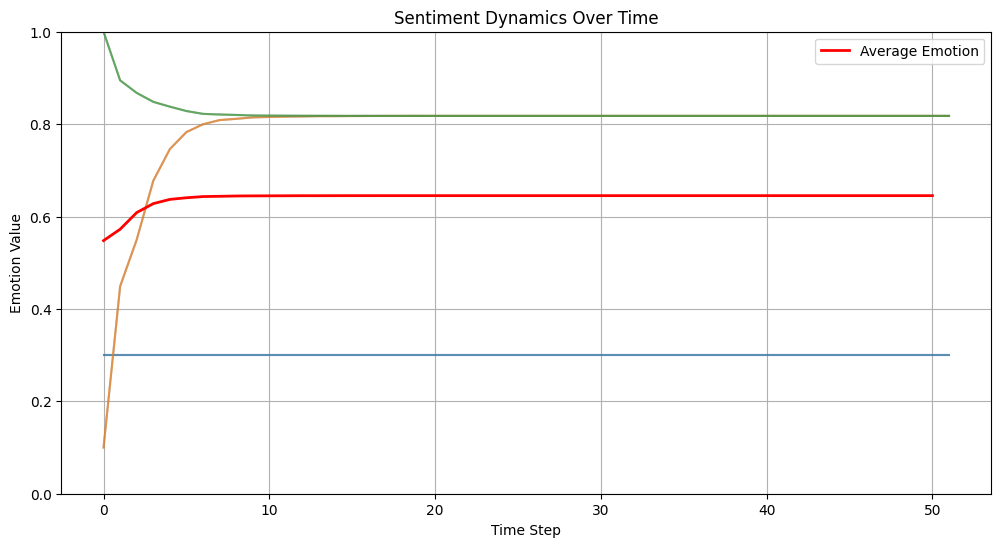

In [ ]:
#os.makedirs(folderpath, exist_ok=True)
runs = 1
all_avg_emotion_list, all_interventions_list, networkG, networkDG, NetworkDictionary = run_multiple_simulations(runs=runs)

# save intervention data
#interventionpath = os.path.join(folderpath, f"Intervention")
#os.makedirs(folderpath, exist_ok=True)
df_interventions = pd.DataFrame({
    "Run": list(range(1, runs + 1)),
    "Intervention_Timesteps": [','.join(map(str, run)) for run in all_interventions_list],
    "Num_Interventions": [len(run) for run in all_interventions_list]
})

binary_matrix = np.zeros((runs, 501), dtype=int)  # 501 timesteps for full duration: Time 0 to Time 500
for i, run in enumerate(all_interventions_list):
    for t in run:
        binary_matrix[i, t] = 1

df_bool = pd.DataFrame(binary_matrix).T  # shape: (501, runs)
#df_bool.to_csv(os.path.join(folderpath, f"Intervention_BooleanMatrix_{style}.csv"), index=False)

# Exploratory Network Analysis

We've got two lists of graphs, so keep in mind that the analysis we do might have to be done over all of them

In [17]:
import igraph as ig

# convert to igraph
h = ig.Graph.from_networkx(networkG[2])  # using the last run's network for plotting

# Plot the same network with NetworkX and igraph
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# NetworkX draw
ax0.set_title("Plot with NetworkX draw")
nx.draw_kamada_kawai(networkG[2], node_size=50, ax=ax0)

# igraph draw
ax1.set_title("Plot with igraph plot")
layout = h.layout_kamada_kawai()
ig.plot(h, layout=layout, target=ax1)
plt.axis("off")
plt.show()


f = ig.Graph.from_networkx(networkDG[2])  # using the last run's network for plotting

# Plot the same network with NetworkX and igraph
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# NetworkX draw
ax0.set_title("Plot with NetworkX draw")
nx.draw_kamada_kawai(networkDG[2], node_size=50, ax=ax0)

# igraph draw
ax1.set_title("Plot with igraph plot")
layout = f.layout_kamada_kawai()
ig.plot(f, layout=layout, target=ax1)
plt.axis("off")
plt.show()

IndexError: list index out of range

In [ ]:
# G: interaction frequency between agents
rows = []
for idx, G in enumerate(networkG):
    row = {"Simulation": idx}

    # Basic properties
    row["Node Count"] = G.number_of_nodes()
    row["Edge Count"] = G.number_of_edges()
    row["Density"] = nx.density(G)

    # Components
    row["Connected Components"] = nx.number_connected_components(G)

    # Clustering
    row["Transitivity"] = nx.transitivity(G)
    row["Avg Clustering"] = nx.average_clustering(G) # average clustering coefficient

    # Connectivity
    row['Node Connectivity'] = nx.node_connectivity(G)
    row['Average Node Connectivity'] = nx.average_node_connectivity(G)
    row['Edge Connectivity'] = nx.edge_connectivity(G)
    row["Avg Shortest Path"] = nx.average_shortest_path_length(G)
    row["Diameter"] = nx.diameter(G)
    row["Radius"] = nx.radius(G)

    # Communities
    try:
        communities_mod = list(nx.community.greedy_modularity_communities(G))
        row["# Modularity Communities"] = len(communities_mod)
    except:
        row["# Modularity Communities"] = None

    try:
        communities_label = list(nx.community.label_propagation_communities(G))
        row["# Label Communities"] = len(communities_label)
    except:
        row["# Label Communities"] = None

    rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)

# Display it nicely
print(df.to_string(index=False))

 Simulation  Node Count  Edge Count  Density  Connected Components  Transitivity  Avg Clustering  Node Connectivity  Average Node Connectivity  Edge Connectivity  Avg Shortest Path  Diameter  Radius  # Modularity Communities  # Label Communities
          0          10          45      1.0                     1           1.0             1.0                  9                        9.0                  9                1.0         1       1                         1                    1
          1          10          45      1.0                     1           1.0             1.0                  9                        9.0                  9                1.0         1       1                         1                    1
          2          10          45      1.0                     1           1.0             1.0                  9                        9.0                  9                1.0         1       1                         1                    1


In [ ]:
# Per node measures:
node_rows = []
for idx, G in enumerate(networkG):
    try:
        deg_centrality = nx.degree_centrality(G)
        btw_centrality = nx.betweenness_centrality(G)
        cls_centrality = nx.closeness_centrality(G)
        eig_centrality = nx.eigenvector_centrality(G)
        triangles = nx.triangles(G)
        clustering = nx.clustering(G)
    except:
        continue  # if any centrality fails (e.g., eigenvector on disconnected graph)

    for node in G.nodes():
        row = {
            "Simulation": idx,
            "Node": node,
            "Degree Centrality": deg_centrality.get(node),
            "Betweenness Centrality": btw_centrality.get(node),
            "Closeness Centrality": cls_centrality.get(node),
            "Eigenvector Centrality": eig_centrality.get(node),
            "Triangle Count": triangles.get(node),
            "Clustering Coefficient": clustering.get(node),
        }
        node_rows.append(row)

# Create DataFrame
node_df = pd.DataFrame(node_rows)

# Display the full node-level table
print(node_df.to_string(index=False))

 Simulation  Node  Degree Centrality  Betweenness Centrality  Closeness Centrality  Eigenvector Centrality  Triangle Count  Clustering Coefficient
          0     0                1.0                     0.0                   1.0                0.316228              36                     1.0
          0     1                1.0                     0.0                   1.0                0.316228              36                     1.0
          0     2                1.0                     0.0                   1.0                0.316228              36                     1.0
          0     3                1.0                     0.0                   1.0                0.316228              36                     1.0
          0     4                1.0                     0.0                   1.0                0.316228              36                     1.0
          0     5                1.0                     0.0                   1.0                0.316228            

In [ ]:
# DG: how much the agents influenced each other -- the cumaltive change in emotion valence, not the net-change in their emotion valence
rows = []
for idx, DG in enumerate(networkDG):
    row = {"Simulation": idx}

    # Basic properties
    row["Node Count"] = DG.number_of_nodes()
    row["Edge Count"] = DG.number_of_edges()
    row["Density"] = nx.density(DG)

    # Components
    row["Weakly Connected Components"] = nx.number_weakly_connected_components(DG)
    row["Strongly Connected Components"] = nx.number_strongly_connected_components(DG)

    # Clustering
    row["Transitivity"] = nx.transitivity(DG)
    row['Node Clustering'] = nx.clustering(DG)  # node clustering coefficient
    row["Avg Clustering"] = nx.average_clustering(DG) # average clustering coefficient

    # Connectivity
    row['Edge Connectivity'] = nx.edge_connectivity(DG)
    row["Avg Shortest Path"] = nx.average_shortest_path_length(DG)
    row["Diameter"] = nx.diameter(DG)
    row["Radius"] = nx.radius(DG)

    # Communities
    try:
        communities_mod = list(nx.community.greedy_modularity_communities(DG))
        row["# Modularity Communities"] = len(communities_mod)
    except:
        row["# Modularity Communities"] = None

    try:
        communities_label = list(nx.community.greedy_modularity_communities(DG))
        row["# Label Communities"] = len(communities_label)
    except:
        row["# Label Communities"] = None

    rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)

# Display it nicely
print(df.to_string(index=False))

 Simulation  Node Count  Edge Count  Density  Weakly Connected Components  Strongly Connected Components  Transitivity                                                                  Node Clustering  Avg Clustering  Edge Connectivity  Avg Shortest Path  Diameter  Radius  # Modularity Communities  # Label Communities
          0          10          90      1.0                            1                              1           1.0 {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}             1.0                  9                1.0         1       1                         1                    1
          1          10          90      1.0                            1                              1           1.0 {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}             1.0                  9                1.0         1       1                         1                    1
          2          10          90      1.

In [ ]:
# Per node measures:
node_rows = []
for idx, DG in enumerate(networkDG):
    try:
        deg_centrality = nx.degree_centrality(DG)
        btw_centrality = nx.betweenness_centrality(DG)
        cls_centrality = nx.closeness_centrality(DG)
        eig_centrality = nx.eigenvector_centrality(DG)
        clustering = nx.clustering(DG)
    except:
        continue  # if any centrality fails (e.g., eigenvector on disconnected graph)

    for node in DG.nodes():
        row = {
            "Simulation": idx,
            "Node": node,
            "Degree Centrality": deg_centrality.get(node),
            "Betweenness Centrality": btw_centrality.get(node),
            "Closeness Centrality": cls_centrality.get(node),
            "Eigenvector Centrality": eig_centrality.get(node),
            "Clustering Coefficient": clustering.get(node)
        }
        node_rows.append(row)

# Create DataFrame
node_df = pd.DataFrame(node_rows)

# Display the full node-level table
print(node_df.to_string(index=False))

 Simulation  Node  Degree Centrality  Betweenness Centrality  Closeness Centrality  Eigenvector Centrality  Clustering Coefficient
          0     0                2.0                     0.0                   1.0                0.316228                     1.0
          0     1                2.0                     0.0                   1.0                0.316228                     1.0
          0     2                2.0                     0.0                   1.0                0.316228                     1.0
          0     3                2.0                     0.0                   1.0                0.316228                     1.0
          0     4                2.0                     0.0                   1.0                0.316228                     1.0
          0     5                2.0                     0.0                   1.0                0.316228                     1.0
          0     6                2.0                     0.0                   1.0 